# Programming Exercise 2: Logistic Regression

The following homework is based on WEEK 3 of the Machine Learning course done by Andrew NG and graded making use of [Python Programming Assignments](https://github.com/dibgerge/ml-coursera-python-assignments) 



## 1 Logistic Regression

<i> Requirements: </i>

- build a logistic regression model to
predict whether a student gets admitted into a university.


Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their
<b> results on two exams </b>. You have historical data from previous applicants
that you can use as a training set for logistic regression. For each training
example, <b> you have the applicant’s scores on two exams and the admissions
decision. </b>
Your task is to build a <u> classification model </u> that estimates an applicant’s
probability of admission based the scores from those two exams

In [114]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import seaborn as sns


import utils

grader = utils.Grader()

%matplotlib inline

# Disable jedi autocompleter
%config Completer.use_jedi = False


In [115]:
data = pd.read_csv('Data/ex2data1.txt',sep=',',header=None,names=["first_exam","second_exam","Results"])
df = pd.DataFrame(data)

X, y = df[df.columns[0:2]], df[df.columns[-1]] # Define features and target variable 

# (Ungraded) Plotting the data

In [116]:
df.describe()

,first_exam,second_exam,Results
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


<AxesSubplot:xlabel='first_exam', ylabel='Count'>

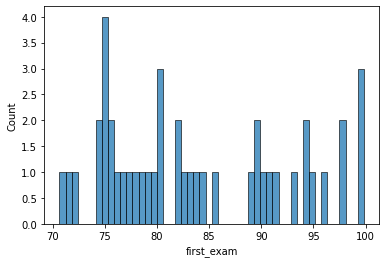

In [117]:
sns.histplot( df.first_exam[df.first_exam>70] ,bins=50)

In [118]:
X.first_exam



0     34.623660
1     30.286711
2     35.847409
3     60.182599
4     79.032736
        ...    
95    83.489163
96    42.261701
97    99.315009
98    55.340018
99    74.775893
Name: first_exam, Length: 100, dtype: float64

Creating a Crossplot/Scatterplot

In [119]:
import collections

collections.Counter(y)

Counter({0: 40, 1: 60})

In [120]:
#from matplotlib import colors
def plotData(X, y):
    plt.rcParams['figure.figsize'] = (8,8)

    #cmap = colors.ListedColormap(['blue', 'red'])

    plt.scatter(X.first_exam,X.second_exam,c=y, marker='x' ,vmin=0,vmax=1,cmap='rainbow') # c represents the target variable

    plt.ylabel("Second Exam Scores",fontsize=14)
    plt.xlabel("First Exam Scores",fontsize=14)

    plt.colorbar(label='Values of target Y')

    plt.show()

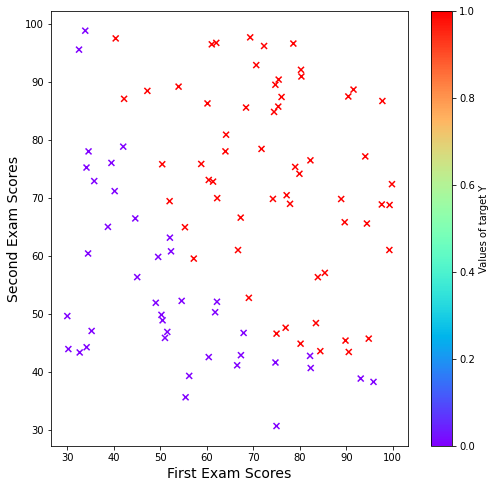

In [121]:
plotData(X, y)


The values of `y` represent if a student is not admitted, if he is admitted the color yields a violet color , otherwise it yields green

<a id="section1"></a>

### 1.2 Implementation

#### 1.2.1 Warmup exercise: sigmoid function

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$

Your first step is to implement this function `sigmoid` so it can be
called by the rest of your program. When you are finished, try testing a few
values by calling `sigmoid(x)` in a new cell. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**
<a id="sigmoid"></a>

In [122]:
def sigmoid(z):
    z = np.array(z)
    return 1 / (1+ np.exp(-z))

In [123]:
sigmoid(y)

array([0.5       , 0.5       , 0.5       , 0.73105858, 0.73105858,
       0.5       , 0.73105858, 0.73105858, 0.73105858, 0.73105858,
       0.5       , 0.5       , 0.73105858, 0.73105858, 0.5       ,
       0.73105858, 0.73105858, 0.5       , 0.73105858, 0.73105858,
       0.5       , 0.73105858, 0.5       , 0.5       , 0.73105858,
       0.73105858, 0.73105858, 0.5       , 0.5       , 0.5       ,
       0.73105858, 0.73105858, 0.5       , 0.73105858, 0.5       ,
       0.5       , 0.5       , 0.73105858, 0.5       , 0.5       ,
       0.73105858, 0.5       , 0.73105858, 0.5       , 0.5       ,
       0.5       , 0.73105858, 0.73105858, 0.73105858, 0.73105858,
       0.73105858, 0.73105858, 0.73105858, 0.5       , 0.5       ,
       0.5       , 0.73105858, 0.5       , 0.73105858, 0.73105858,
       0.73105858, 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.73105858, 0.5       , 0.73105858, 0.73105858,
       0.5       , 0.73105858, 0.73105858, 0.73105858, 0.73105

In [124]:
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


In [125]:
# appends the implemented function in part 1 to the grader object
grader[1] = sigmoid

# send the added functions to coursera grader for getting a grade on this part
grader.grade()


Submitting Solutions | Programming Exercise logistic-regression

Invalid email or token. You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


In [126]:
# preparing the data for logistic regression
m, n = X.shape
# Setup the data matrix appropriately, and add ones for the intercept term

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)

n = n + 1

In [127]:
def h_theta(X,theta):
    return sigmoid(np.dot(X,theta))

In [128]:

def costFunction(theta, X, y):

    Element = -y * (np.log(h_theta(X,theta))) -  (1-y) * np.log(1-h_theta(X,theta))
    
    J_theta=  np.sum(Element)/m

    return J_theta
    

In [129]:

theta= np.zeros(n)
theta= theta.reshape(n,1)


L=costFunction(theta,X,y.values.reshape(-1,1))  
L

0.6931471805599453

Implementing: 
$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

In [130]:
def gradient(theta,X,y):
        Element = (h_theta(X,theta) - y)
        gradient = np.divide(np.dot(X.transpose(),Element),m)
        return gradient

In [131]:
def GradientDescent(X,y,theta,alpha,iterations):
    for _ in range(iterations):
        dJ = gradient(theta,X,y)
        theta = theta - np.multiply(alpha/m,dJ)
    return theta

theta_optimized = GradientDescent(X, y.values.reshape(-1,1), theta, alpha=0.01, iterations=500000)

display(theta_optimized)

array([[-2.84944923],
       [ 0.03070159],
       [ 0.0227594 ]])

In [132]:
L= costFunction(theta_optimized,X,y.values.reshape(-1,1)
)
L

0.465105186367423

# Learning parameters using fminunc

In python `fmin_tnc` allows us to find the optimal parameter $\theta$ for logistic regression.

In [133]:
import scipy.optimize as opt

temp = opt.fmin_tnc(func = costFunction, 
                    x0 = theta.flatten(),fprime = gradient, 
                    args = (X, y.values.flatten()))
#the output of above function is a tuple whose first element #contains the optimized values of theta
theta_optimized = temp[0]
print(theta_optimized)

[-25.16131846   0.20623159   0.20147148]


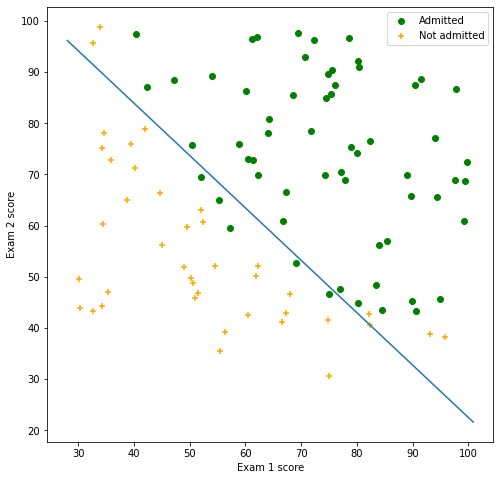

In [134]:
plot_x = [np.min(X[:,1]-2), np.max(X[:,2]+2)]


plot_y = -1/theta_optimized[2]*(theta_optimized[0] 
          + np.dot(theta_optimized[1],plot_x))  


mask = y.values.flatten() == 1

adm = plt.scatter(X[mask][:,1], X[mask][:,2],color="green")

not_adm = plt.scatter(X[~mask][:,1], X[~mask][:,2],marker="+",color="orange")



decision_boun = plt.plot(plot_x, plot_y)


plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')

plt.legend((adm, not_adm), ('Admitted', 'Not admitted'))


plt.show()


In [135]:
theta_optimized

array([-25.16131846,   0.20623159,   0.20147148])

In [136]:
# Finding the new cost value

J = costFunction(theta_optimized,X,y.values.flatten())
J

0.20349770158947528

# Finding the Acuraccy of the Model

` Using a 0.5 threeshold `

In [137]:
def find_Acurracy(X,y,theta,threshold):
    pred = h_theta(X,theta) >= threshold
    accuracy = np.mean(pred==y)
    return accuracy

display(find_Acurracy(X,y.values.flatten(),theta_optimized,0.5))

0.89

In [138]:
def predict(theta, X):
    prediction = h_theta(X,theta)
    return prediction

Acurracy of $ 89 \%$ 

# Testing the model

- For a student with an Exam 1 score
of 45 and an Exam 2 score of 85, you should expect to see an admission
probability of 0.776.

In [139]:
X_test = [1,45,85] # append 1

prob = predict(theta_optimized,X_test)

print('Admission probability of the student : {:.3f}'.format(prob))

Admission probability of the student : 0.776


For a student with an Exam 1 score of 45 and an Exam 2 score of 85, 

In [140]:
grader[4] = predict
grader.grade()


Submitting Solutions | Programming Exercise logistic-regression

Invalid email or token. You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


# 2 Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression
to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure
it is functioning correctly.

`ex2_reg.m` will be used for this exercise

## 2.1 Visualizing the data


In [141]:
# loading the data from ex2data2.txt

data = pd.read_csv('Data/ex2data2.txt',sep=',',header=None,names=["Microchip_Test_2","Microchip_Test_1","Results"])
df = pd.DataFrame(data)

X, y = df[df.columns[0:2]], df[df.columns[-1]] # Define features and target variable

In [142]:
#from matplotlib import colors
def plotData(X, y):
    plt.rcParams['figure.figsize'] = (8,8)

    #cmap = colors.ListedColormap(['blue', 'red'])

    mask = (y.values.flatten()==1) # mask that selects only those points that satisfy y == 1 :

    #  y == 1 :
    adm = plt.scatter(X[mask]["Microchip_Test_2"], X[mask]["Microchip_Test_1"],color="yellow",edgecolors='black')
    #  y == 0 :
    not_adm = plt.scatter(X[~mask]["Microchip_Test_2"], X[~mask]["Microchip_Test_1"],marker="x",color="#9A2A2A")


    plt.ylabel("Microchip_Test_2",fontsize=14)
    plt.xlabel("Microchip_Test_1",fontsize=14)

    plt.legend((adm, not_adm), ('Admitted', 'Not admitted'))


    plt.show()


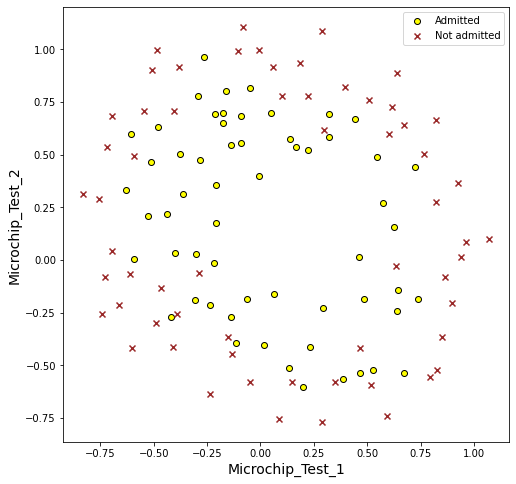

In [143]:
plotData(X, y)


# Feature Mapping

We create more features from each data point , to fit the data better , in this case , we will map the features into polynomial terms of $x_1$ and $x_2$ to the sixth degree

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$


In [144]:
def mapFeature(X1,X2,degree):
    out = np.ones(X.shape[0])[:,np.newaxis]
    for i in range (1,degree+1):
        for j in range (i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j),np.power(X2, j))[:,np.newaxis]))  
            # stack arrays in sequence horizontally
    return out

In [145]:
# using  map Feature

X = mapFeature(X.iloc[:, 0], X.iloc[:, 1],6)

C:\Users\Det-Pc\AppData\Local\Temp/ipykernel_8532/1591120241.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out = np.hstack((out, np.multiply(np.power(X1, i-j),np.power(X2, j))[:,np.newaxis]))


In [146]:
X,y

(array([[ 1.00000000e+00,  5.12670000e-02,  6.99560000e-01, ...,
          6.29470940e-04,  8.58939846e-03,  1.17205992e-01],
        [ 1.00000000e+00, -9.27420000e-02,  6.84940000e-01, ...,
          1.89305413e-03, -1.39810280e-02,  1.03255971e-01],
        [ 1.00000000e+00, -2.13710000e-01,  6.92250000e-01, ...,
          1.04882142e-02, -3.39734512e-02,  1.10046893e-01],
        ...,
        [ 1.00000000e+00, -4.84450000e-01,  9.99270000e-01, ...,
          2.34007252e-01, -4.82684337e-01,  9.95627986e-01],
        [ 1.00000000e+00, -6.33640000e-03,  9.99270000e-01, ...,
          4.00328554e-05, -6.31330588e-03,  9.95627986e-01],
        [ 1.00000000e+00,  6.32650000e-01, -3.06120000e-02, ...,
          3.51474517e-07, -1.70067777e-08,  8.22905998e-10]]),
 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 113    0
 114    0
 115    0
 116    0
 117    0
 Name: Results, Length: 118, dtype: int64)

Now , lets implement the cost function and gradient for regularized logistic regression. Recalling , the regularized cost function in lr is :

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

In [147]:
# getting m and n values

m,n = X.shape

In [148]:
X.shape # 28 dimensional vector

(118, 28)

In [149]:
def costFunctionReg(theta, X, y, lambda_r):
    
    Element =   np.matmul(-y, (np.log(h_theta(X,theta)))) -  np.matmul((1-y),np.log(1-h_theta(X,theta)))
    
    c_r = (Element)/m
    
    # for j >= 1
    

    reg_term = np.divide(lambda_r,(2*m)) * np.matmul(np.transpose(theta[1:]),theta[1:])    
   
    c_r = c_r + reg_term 
    
    
    
    
    return c_r
    

In [150]:
def lr_gradient(theta,X,y,lambda_r):
    
    grad = np.zeros(theta.shape)
        
    gradient  = (1/m) * np.matmul(np.transpose(X),( h_theta(X,theta) - y ))
    
    reg_term = lambda_r/m * theta[1:]
    
    gradient[1:] = gradient[1:] + reg_term
    
    return gradient

In [151]:
theta= np.zeros(n)
theta= theta.reshape(n,1)
lmbda = 1
J = costFunctionReg(theta, X, y.values.flatten(), lmbda)
print(J)

[[0.69314718]]


In [152]:
output = opt.fmin_tnc(func = costFunctionReg, x0 = theta.flatten(), fprime = lr_gradient, \
                         args = (X, y.values.flatten(), lmbda))
theta = output[0]
print(theta) # theta contains the optimized values

[ 1.27271025  0.62529964  1.18111687 -2.019874   -0.91743189 -1.43166928
  0.12393228 -0.36553119 -0.35725406 -0.17516293 -1.45817007 -0.05098418
 -0.61558563 -0.27469165 -1.192713   -0.24217841 -0.20603308 -0.04466177
 -0.27778944 -0.29539513 -0.45645981 -1.04319152  0.02779374 -0.29244859
  0.01555758 -0.32742401 -0.14389149 -0.92467488]


In [153]:
pred = [h_theta(X,theta) >= 0.5]
np.mean(pred == y.values.flatten()) * 100

83.05084745762711

83 % of accuracy in the optimal model

In [154]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_r = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = costFunctionReg(initial_theta, X, y, lambda_r), lr_gradient(theta,X,y,lambda_r)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10), lr_gradient(theta,X,y,10)

print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at test theta - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Cost at initial theta (zeros): 0.693
Expected cost (approx)       : 0.693

Gradient at initial theta (zeros) - first five values only:
	[-0.0000, 0.0000, -0.0000, 0.0000, -0.0000]
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Cost at test theta    : 3.16
Expected cost (approx): 3.16

Gradient at test theta - first five values only:
	[-0.0000, 0.0477, 0.0901, -0.1541, -0.0700]
Expected gradients (approx) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


In [155]:

def mapFeatureForPlotting(X1, X2): 
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out

In [156]:
 
def PlotData(X,y,theta):
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    z = np.zeros((len(u), len(v)))

    for i in range(len(u)):
        for j in range(len(v)):
            z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j]), theta)
            
    mask = y.values.flatten() == 1
    X = data.iloc[:,:-1]


    adm = plt.scatter(X[mask]["Microchip_Test_2"], X[mask]["Microchip_Test_1"],color="yellow",edgecolors='black')
        #  y == 0 :
    not_adm = plt.scatter(X[~mask]["Microchip_Test_2"], X[~mask]["Microchip_Test_1"],marker="x",color="#9A2A2A")


    plt.contour(u,v,z,0)

    plt.xlabel('Microchip Test1')
    plt.ylabel('Microchip Test2')

    plt.legend((adm, not_adm), ('Passed', 'Failed'))
    plt.show()

Training data with decision boundary ($\lambda=1$)

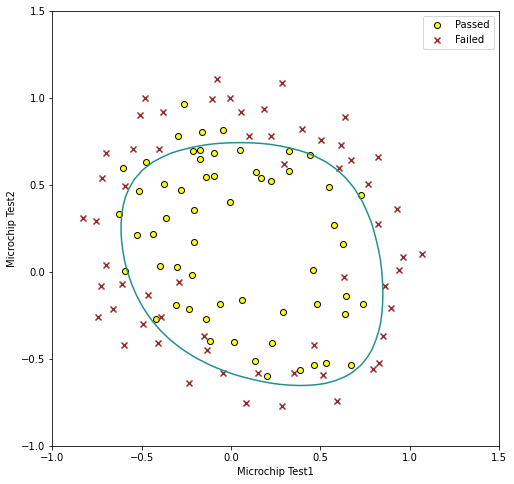

In [157]:
PlotData(X,y, theta)

In [158]:
 
def lambda_theta(theta,lmbda):
    J = costFunctionReg(theta, X, y.values.flatten(), lmbda)
    output = opt.fmin_tnc(func = costFunctionReg, x0 = theta.flatten(), fprime = lr_gradient, \
                            args = (X, y.values.flatten(), lmbda))
    theta = output[0]
    
    return theta

<IPython.core.display.Latex object>

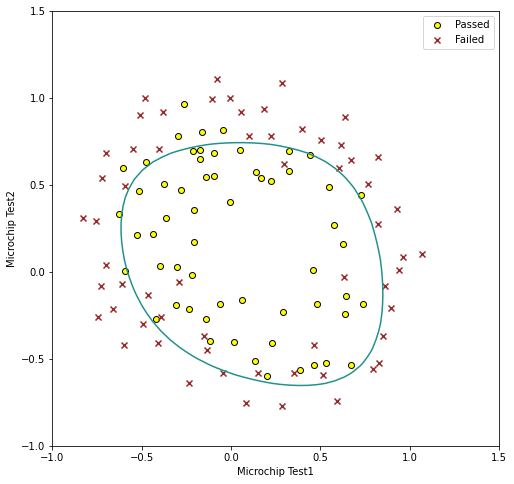

<IPython.core.display.Latex object>

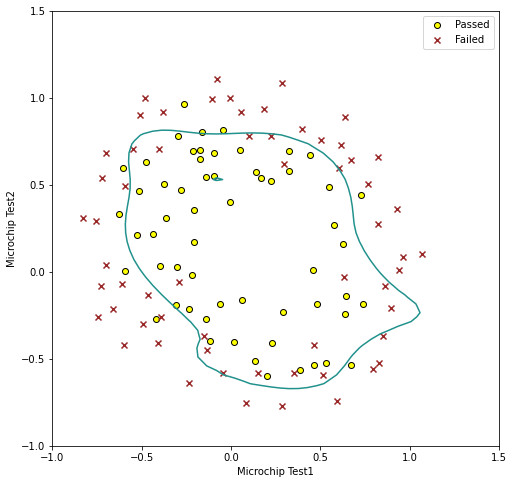

<IPython.core.display.Latex object>

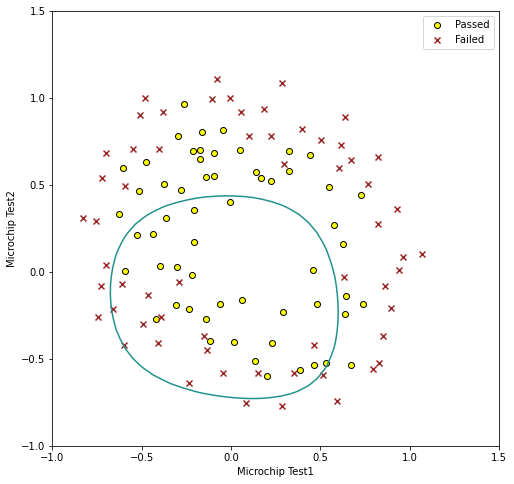

In [163]:
from IPython.display import display, Math, Latex



display(Latex('For $$\lambda=1$$ '))


PlotData(X,y,lambda_theta(theta,lmbda=1))


display(Latex('For $$\lambda=0 \quad (Underfitting) $$ '))

PlotData(X,y,lambda_theta(theta,lmbda=0))
display(Latex('For $$\lambda=100 \quad (Overfitting ) $$  '))


PlotData(X,y,lambda_theta(theta,lmbda=100))
